### In this study we aim to get an insight on the distribution of pixel intensities in our dataset.

### This would enable to later come up with a method that suggests suspicious regions as defects based on the values of pixels in the inspected image compared to the Range of Values (ROV) these pixels should have based on the reference image.

In [1]:
import cv2
import seaborn as sns
import numpy as np
from utils import quickshow, get_case_defects, overlay_region_masks
import os
from analyses.contours import get_smoothened_contours, contours_to_masks
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Some helper functions

def calc_stats_array(array):# Calculate mean and standard deviation for each array
    stats = {}
    # mean and std_dev
    stats['mean'] = np.mean(array)
    stats['std_dev'] = np.std(array)
    
    # Define upper and lower thresholds
    stats['upper_threshold'] = stats['mean'] + 3 * stats['std_dev']
    stats['lower_threshold'] = stats['mean'] - 3 * stats['std_dev']
    
    return stats

def img_into_segmented_pixel_arrays(img):

    sm_cont_img = get_smoothened_contours(img)
    mask_in, mask_edges, mask_out = contours_to_masks(sm_cont_img, img.shape[0:2], thickness=10)

    img_cpy = img.copy()
    overlayed_img = overlay_region_masks(img_cpy, mask_in, mask_out, mask_edges)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    img_in = cv2.bitwise_and(mask_in, img_gray)
    pixels_in_cont = img_in[img_in>0]
    pixels_in.append(pixels_in_cont)

    img_out = cv2.bitwise_and(mask_out, img_gray)
    pixels_out_cont = img_out[img_out > 0]
    pixels_out.append(pixels_out_cont)
    
    return pixels_out_cont, pixels_in_cont

In [3]:
 path_main = r"E:\Desktop\Academy\Job_Search\HomeEx\MuzeAI\home_exercise".replace('\\', '/')
path_res = os.path.join(path_main, "results")
path_stat_file = os.path.join(path_res, 'reference_image_stats.txt')
path_defect = os.path.join(path_main, "defective_examples")
path_non_defect = os.path.join(path_main, "non_defective_examples")
# defect_loc_path = os.path.join(path_defect, "defects locations.txt")

defect_cases = [1, 2]
non_defect_cases = [3]

# Segmenting Reference Images to Regions

### We segment into Bright and Dark regions in order to learn the statistics of pixels in each region


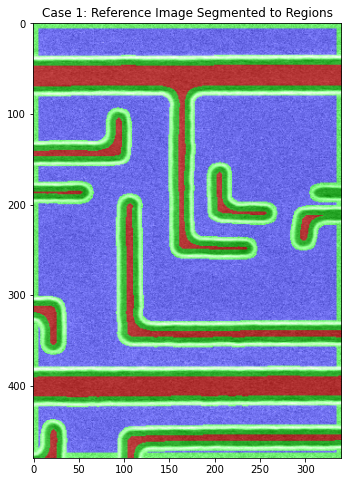

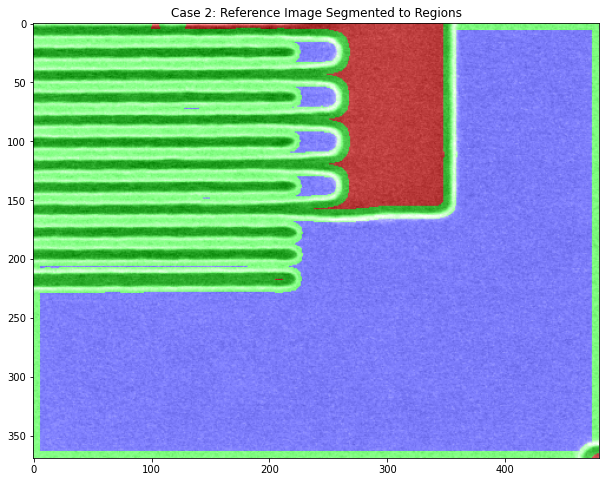

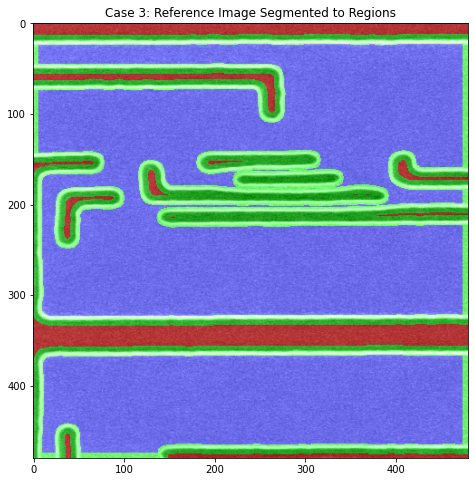

In [4]:
##### Get statistics on the reference Images (**Only** reference images):

ref_images = {}
for folder in [path_defect, path_non_defect]:
    files = os.listdir(folder)
    for file in files:
        if 'reference' in file:
            img = cv2.imread(os.path.join(folder,file))
            case = int(file.split('_')[0].strip('case'))
            ref_images[case] = img

pixels_in = []
pixels_out = []

for case in ref_images:
    ref = ref_images.get(case)
    sm_cont_ref = get_smoothened_contours(ref)
    ref_cpy = ref.copy()

    mask_in, mask_edges, mask_out = contours_to_masks(sm_cont_ref, ref.shape[0:2], thickness=10)
    
    overlayed_img = overlay_region_masks(ref_cpy, mask_in, mask_out, mask_edges)
    quickshow(overlayed_img)
    fig = plt.gcf()
    fig.set_size_inches(15, 8)
    
    plt.title(f'Case {case}: Reference Image Segmented to Regions')
    cv2.imwrite(os.path.join(path_res, f'overlay_case{case}_reference.tiff'),overlayed_img)

    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)

    ref_in = cv2.bitwise_and(mask_in, ref_gray)
    # quickshow(ref_in)
    pixels_in_cont = ref_in[ref_in>0]
    pixels_in.append(pixels_in_cont)

    ref_out = cv2.bitwise_and(mask_out, ref_gray)
    pixels_out_cont = ref_out[ref_out > 0]
    pixels_out.append(pixels_out_cont)
    # quickshow(ref_out)

pixels_in_tot = np.concatenate(pixels_in)
pixels_out_tot = np.concatenate(pixels_out)

stats_in = calc_stats_array(pixels_in_tot)
stats_out = calc_stats_array(pixels_out_tot)

if os.path.exists(path_stat_file):
    pass
else:
    with open(path_stat_file, 'w') as f:
        f.write("In contour (bright) pixels:\n")
        f.write(f'mean={stats_in["mean"]}\n')
        f.write(f'std_dev={stats_in["std_dev"]}\n')
        f.write(f'thresh_low={stats_in["lower_threshold"]}\n')
        f.write(f'thresh_high={stats_in["upper_threshold"]}\n')
        f.write(f'\n')
        f.write("Out of contour (dark) pixels:\n")
        f.write(f'mean={stats_out["mean"]}\n')
        f.write(f'std_dev={stats_out["std_dev"]}\n')
        f.write(f'thresh_low={stats_out["lower_threshold"]}\n')
        f.write(f'thresh_high={stats_out["upper_threshold"]}\n')



# Pixel Intensity Histogram - Dark Regions Vs. Bright Regions

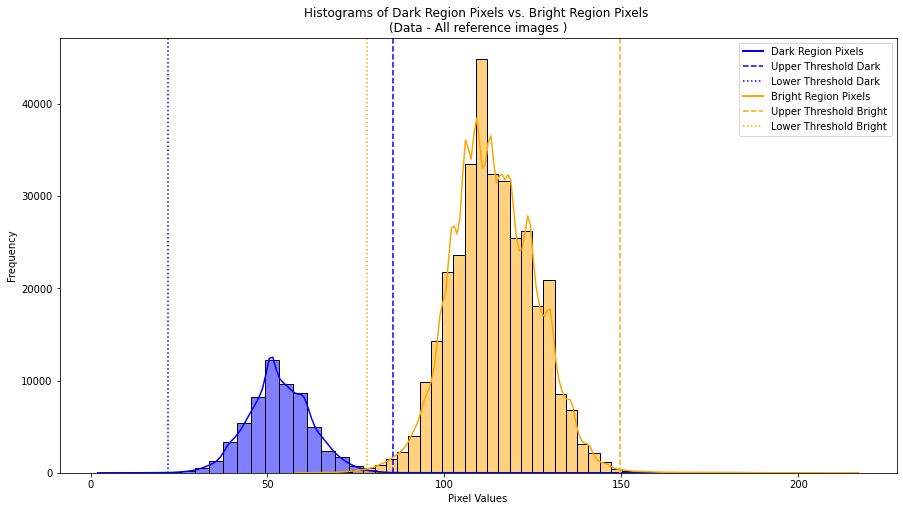

In [5]:
# Calculate mean and standard deviation for each array


stats_in = calc_stats_array(pixels_in_tot)
stats_out = calc_stats_array(pixels_out_tot)

fig = plt.figure(figsize=(15, 8))

hist_dark = sns.histplot(pixels_out_tot, bins=50, color='blue', label='Pixels Dark Regions', kde=True)
dark_upper_thresh = plt.axvline(stats_out['upper_threshold'], color='blue', linestyle='--', linewidth=1.5, label='Upper Threshold Dark')
dark_lower_thresh = plt.axvline(stats_out['lower_threshold'], color='blue', linestyle=':', linewidth=1.5, label='Lower Threshold Dark')


hist_bright = sns.histplot(pixels_in_tot, bins=50, color='orange', label='Pixels Bright Regions', kde=True)
bright_upper_thresh = plt.axvline(stats_in['upper_threshold'], color='orange', linestyle='--', linewidth=1.5, label='Upper Threshold Bright')
bright_lower_thresh = plt.axvline(stats_in['lower_threshold'], color='orange', linestyle=':', linewidth=1.5, label='Lower Threshold Bright')



# Add labels and legend
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Dark Region Pixels vs. Bright Region Pixels \n(Data - All reference images )')


legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Dark Region Pixels'),
    Line2D([0], [0], color='blue', linestyle='--', lw=1.5, label='Upper Threshold Dark'),
    Line2D([0], [0], color='blue', linestyle=':', lw=1.5, label='Lower Threshold Dark'),
    Line2D([0], [0], color='orange', lw=2, label='Bright Region Pixels'),
    Line2D([0], [0], color='orange', linestyle='--', lw=1.5, label='Upper Threshold Bright'),
    Line2D([0], [0], color='orange', linestyle=':', lw=1.5, label='Lower Threshold Bright')
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='upper right', ncol=1)
plt.show()
fig.savefig(os.path.join(path_res,'Histograms_Dark_Region_vs_Bright_Region_All_Reference_Images.png'))




# Region Isolated Pixel Intensity Histogram - Case 1 Vs. Case 2


### We want to check whether, within each region (either dark or bright), the distribution of intensity values is similar across the different images in the dataset. If the distribution is consistent across images, we can propose threshold values for defect detection based on the statistics of that region across the entire reference image dataset. However, if the intensity distribution varies significantly, we will use the threshold values derived solely from the reference image corresponding to the inspected image.


Text(0.5, 1.0, 'case 2: Reference Image')

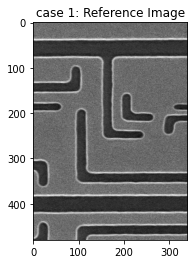

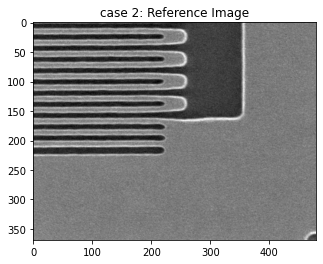

In [6]:
case = 1

ref1 = cv2.imread(os.path.join(path_defect, f"case{case}_reference_image.tif"))
quickshow(ref1)
plt.title(f'case {case}: Reference Image')

case = 2
ref2 = cv2.imread(os.path.join(path_defect, f"case{case}_reference_image.tif"))
quickshow(ref2)
plt.title(f'case {case}: Reference Image')


## Dark Region Pixel Intensity Histogram - Case 1 Vs. Case 2

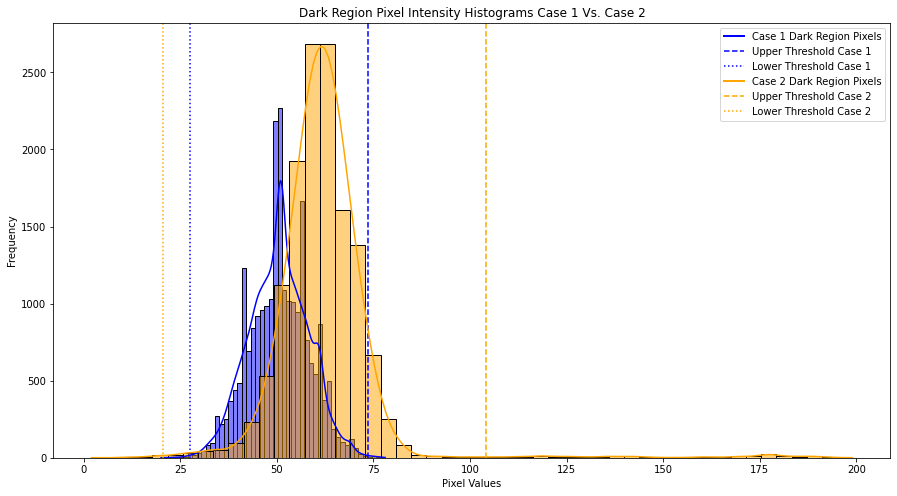

In [7]:
pixels_out1, pixels_in1 = img_into_segmented_pixel_arrays(ref1)
pixels_out2, pixels_in2 = img_into_segmented_pixel_arrays(ref2)

stats_out1 = calc_stats_array(pixels_out1)
stats_out2 = calc_stats_array(pixels_out2)


fig = plt.figure(figsize=(15, 8))

sns.histplot(pixels_out1, bins=50, color='blue', label='Pixels Case 1 Dark Regions', kde=True)
plt.axvline(stats_out1['upper_threshold'], color='blue', linestyle='--', linewidth=1.5, label='Upper Threshold Case 1')
plt.axvline(stats_out1['lower_threshold'], color='blue', linestyle=':', linewidth=1.5, label='Lower Threshold Case 1')


sns.histplot(pixels_out2, bins=50, color='orange', label='Pixels Case 2 Dark Regions', kde=True)
plt.axvline(stats_out2['upper_threshold'], color='orange', linestyle='--', linewidth=1.5, label='Upper Threshold Case 2')
plt.axvline(stats_out2['lower_threshold'], color='orange', linestyle=':', linewidth=1.5, label='Lower Threshold Case 2')



# Add labels and legend
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Dark Region Pixel Intensity Histograms Case 1 Vs. Case 2')


legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Case 1 Dark Region Pixels'),
    Line2D([0], [0], color='blue', linestyle='--', lw=1.5, label='Upper Threshold Case 1'),
    Line2D([0], [0], color='blue', linestyle=':', lw=1.5, label='Lower Threshold Case 1'),
    Line2D([0], [0], color='orange', lw=2, label='Case 2 Dark Region Pixels'),
    Line2D([0], [0], color='orange', linestyle='--', lw=1.5, label='Upper Threshold Case 2'),
    Line2D([0], [0], color='orange', linestyle=':', lw=1.5, label='Lower Threshold Case 2')
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='upper right', ncol=1)
plt.show()
fig.savefig(os.path.join(path_res,'Histograms_Dark_Region_Case1_vs_Case2.png'))





## Bright Region Pixel Intensity Histogram - Case 1 Vs. Case 2

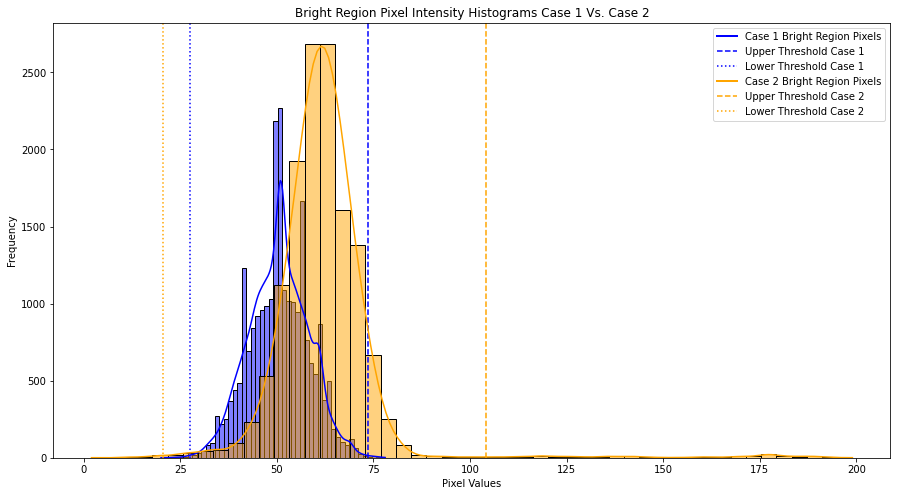

In [8]:

stats_in1 = calc_stats_array(pixels_in1)
stats_in2 = calc_stats_array(pixels_in2)


fig = plt.figure(figsize=(15, 8))

sns.histplot(pixels_out1, bins=50, color='blue', label='Pixels Case 1 Bright Regions', kde=True)
plt.axvline(stats_out1['upper_threshold'], color='blue', linestyle='--', linewidth=1.5, label='Upper Threshold Case 1')
plt.axvline(stats_out1['lower_threshold'], color='blue', linestyle=':', linewidth=1.5, label='Lower Threshold Case 1')


sns.histplot(pixels_out2, bins=50, color='orange', label='Pixels Case 2 Bright Regions', kde=True)
plt.axvline(stats_out2['upper_threshold'], color='orange', linestyle='--', linewidth=1.5, label='Upper Threshold Case 2')
plt.axvline(stats_out2['lower_threshold'], color='orange', linestyle=':', linewidth=1.5, label='Lower Threshold Case 2')



# Add labels and legend
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Bright Region Pixel Intensity Histograms Case 1 Vs. Case 2')


legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Case 1 Bright Region Pixels'),
    Line2D([0], [0], color='blue', linestyle='--', lw=1.5, label='Upper Threshold Case 1'),
    Line2D([0], [0], color='blue', linestyle=':', lw=1.5, label='Lower Threshold Case 1'),
    Line2D([0], [0], color='orange', lw=2, label='Case 2 Bright Region Pixels'),
    Line2D([0], [0], color='orange', linestyle='--', lw=1.5, label='Upper Threshold Case 2'),
    Line2D([0], [0], color='orange', linestyle=':', lw=1.5, label='Lower Threshold Case 2')
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='upper right', ncol=1)
plt.show()
fig.savefig(os.path.join(path_res,'Histograms_Bright_Region_Case1_vs_Case2.png'))



# Conclusion


It is evident that in both the dark and bright regions, there is a noticeable shift in the pixel intensity distribution between the two reference cases. As a result, if we use a method for proposing defects in an inspected image based on deviations from the mean intensity within a region, we will need to rely solely on the statistics of the corresponding reference image for that specific inspection. This is because the intensity distributions differ too much between the reference cases to confidently use dataset-wide statistics for defect detection.
